Before you turn this assignment in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Lastly, hit **Validate**.

If you worked locally, and then uploaded your work to the hub, make sure to follow these steps:
- open your uploaded notebook **on the hub**
- hit the validate button right above this cell, from inside the notebook

These  steps should solve any issue related to submitting the notebook on the hub.

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Yulin Wu"
COLLABORATORS = ""

---

# Project 2: Spam // Ham Prediction  

## Due Date: 11:59pm Sunday, April 29

In this project, you will use what you've learned in class to create a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. In addition to providing some skeleton code to fill in, we will evaluate your work based on your model's accuracy and your written responses in this notebook.

## Score breakdown

Question | Points
--- | ---
Question 1 | 3
Question 2 | 2
Question 3a | 2
Question 3b | 2
Question 4 | 2
Question 5 | 2
Question 6 | 9
Question 7 | 6
Question 8 | 6
Question 9 | 3
Question 10 | 5
Total | 42

# Part I - Initial Analysis

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

In [2]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import cufflinks as cf
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')

ModuleNotFoundError: No module named 'cufflinks'

### Loading in the Data

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labelled dataset contains 8348 labelled examples, and the evaluation set contains 1000 unlabelled examples.

Run the following cells to load in the data into DataFrames.

The `train` DataFrame contains labelled data that you will use to train your model. It contains three columns:

1. `id`: An identifier for the training example.
1. `subject`: The subject of the email
1. `email`: The text of the email.
1. `spam`: 1 if the email was spam, 0 if the email was ham (not spam).

The `evaluation` DataFrame contains another set of 1000 unlabelled examples. You will predict labels for these examples and submit your predictions to Kaggle for evaluation.

In [3]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'eval.csv')

original_training_data = pd.read_csv('data/train.csv')
evaluation = pd.read_csv('data/eval.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
evaluation['email'] = evaluation['email'].str.lower()

original_training_data.head()

ModuleNotFoundError: No module named 'utils'

## Train-Test Split

The training data we downloaded is all the data we have available for both training models and **testing** the models that we train.  We therefore need to split the training data into separate training and test datsets.  You will need this **test data** to evaluate your model once you are finished training.

In [5]:
from sklearn.model_selection import train_test_split

[train, test] = train_test_split(original_training_data, test_size=0.1, random_state=42)

# Question 1

In the cell below, print the text of the first ham and the first spam email in the training set. Then, discuss one thing you notice that is different between the two that might relate to the identification of spam.

In [6]:
# Print the text of the first ham and the first spam emails. Then, fill in your response in the q01 variable:
ham = train.loc[train.loc[:,'spam']==0]
spam = train.loc[train.loc[:,'spam']==1]
first_ham = ham.iloc[0,2]
first_spam = spam.iloc[0,2]
print(first_ham)
print(first_spam)

# YOUR CODE HERE
#raise NotImplementedError()

while i was playing with the past issues, it annoyed me that there was
 no easy way to make the log stop growing (i don't mean to truncate it,
 i mean to just freeze it for a while).
 
 the following patch adds a new button to the log window, which allows
 the log to be switched on/off (the button says "disable" when the
 log is enabled, and the button disables it, and "enable" when the log
 is frozen, and the button enables it again).
 
 kre
 
 --- main.tcl	wed aug 21 15:01:48 2002
 +++ /usr/local/lib/exmh-2.5/main.tcl	wed aug 28 17:36:59 2002
 @@ -385,6 +385,9 @@
  	exmhlogcreate
  	wm withdraw $exmh(logtop)
      }
 +    if {! $exmh(logwrite)} {
 +	return
 +    }
      if [info exists exmh(log)] {
  	catch {
  #	    $exmh(log) insert end " [bw_delta] "
 @@ -407,6 +410,9 @@
      set exmh(logwindow) 1
      exwin_toplevel .log "exmh log" log
      set exmh(logtop) .log
 +    set exmh(logdisablebut) \
 +	[widget_addbut $exmh(logtop).but swap "disable" exmhlogtoggle]
 +    set exmh(log

In [7]:
# This is a cell with just a comment but don't delete me if you want to get credit.

I find that there are a lot of "please" and "transaction" in the spam emails but not a lot in the ham emails.

# Basic Feature Engineering

We would like to take the text of an email and predict whether the text is ham or spam. This is a *classification* problem, so we can use logistic regression to make a classifier. Recall that to train an logistic regression model we need a numeric feature matrix $\Phi$ (pronounced phi as in wifi) and corresponding binary labels $Y$.  Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $\Phi$ is derived from one email example. Each column of $\Phi$  is one feature. We'll guide you through creating a simple feature, and you'll create more interesting ones when you are trying to increase your accuracy.

# Question 2

Create a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It should output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```python
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello world hello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

In [8]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = np.array(np.transpose([texts.str.contains(word) for word in words]),dtype=np.int)

    # YOUR CODE HERE
    
    #raise NotImplementedError()
    return indicator_array

In [9]:
# If this doesn't error, your function outputs the correct output for this example
assert np.allclose(words_in_texts(['hello', 'bye', 'world'], 
                                  pd.Series(['hello', 'hello world hello'])),
                   np.array([[1, 0, 0], 
                             [1, 0, 1]]))

# Basic EDA

Now we need to identify some features that allow us to tell spam and ham emails apart. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.


# Question 3a

Create a bar chart comparing the proportion of spam and ham emails containing certain words. It should look like the following plot (which was created using `sns.barplot`), but you should choose your own words as candidate features.

![training conditional proportions](training_conditional_proportions.png "Class Conditional Proportions")


In [10]:
words = [' free ',' please ',' money ',' click ','!!']
d1_r =  {
      'pro':sum(words_in_texts(words,ham.iloc[:,2]))/len(ham),
      'spam':'Ham'
     }
d2_r = {'pro':sum(words_in_texts(words,spam.iloc[:,2]))/len(spam),
      'spam':'Spam'
     }
pro1_r  = pd.DataFrame(data=d1_r,index=words)
pro2_r = pd.DataFrame(data=d2_r,index=words)
pro_r = pd.concat([pro1_r,pro2_r],axis=0)

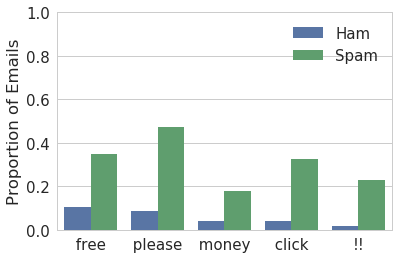

In [11]:
# YOUR CODE HERE

sns.barplot(x=pro_r.index,y='pro',hue='spam',data=pro_r);
plt.ylabel('Proportion of Emails');
plt.legend();
plt.ylim([0,1]);
#raise NotImplementedError()

# Question 3b

When the feature is binary, it makes sense (as in the previous question) to compare the proportion of 1s in the two classes of email. Otherwise, if the feature can take on many values, it makes sense to compare the distribution under spam to the distribution under ham. Create a *class conditional density plot* like the one below (which was created using `sns.distplot`), comparing the distribution of a feature among all spam emails to the distribution of the same feature among all ham emails. **You may use the Fraction of Uppercase Letters or create your own feature.**

![training conditional densities](training_conditional_densities2.png "Class Conditional Densities")

In [12]:
original_data = pd.read_csv('data/train.csv')
original_data.loc[:,'subject'].fillna(' ',inplace=True)
[training_data, testing_data] = train_test_split(original_data, test_size=0.1, random_state=42)

word_num = training_data.iloc[:,2].str.findall('[a-zA-Z]').str.len()
upper_num = training_data.iloc[:,2].str.findall('[A-Z]').str.len()
training_data['Fraction'] = upper_num/word_num


/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



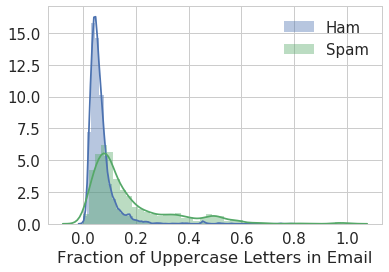

In [13]:
# YOUR CODE HERE
sns.distplot(training_data.loc[training_data['spam']==0,'Fraction'], hist=True,label='Ham');
sns.distplot(training_data.loc[training_data['spam']==1,'Fraction'], hist=True,label='Spam');
plt.legend();
plt.xlabel('Fraction of Uppercase Letters in Email');

#raise NotImplementedError()

# Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

# Question 4

We've given you 5 words that might be useful as features to distinguish spam/ham emails. Use these words as well as the `train` DataFrame to create two NumPy arrays: `Phi_train` and `Y_train`.

`Phi_train` should be a matrix of 0s and 1s created by using your `words_in_texts` function on all the emails in the training set.

`Y_train` should be a vector of the correct labels for each email in the training set.

In [14]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

Phi_train = words_in_texts(some_words,train.iloc[:,2])
Y_train = train.loc[:,'spam']

# YOUR CODE HERE
#raise NotImplementedError()

Phi_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]), 7657    0
 6911    0
 6074    0
 4376    0
 5766    0
 Name: spam, dtype: int64)

In [15]:
assert np.all(np.unique(Phi_train) == np.array([0, 1]))
assert np.all(np.unique(Y_train) == np.array([0, 1]))
assert Phi_train.shape[0] == Y_train.shape[0]
assert Phi_train.shape[1] == len(some_words)

# Question 5

Now we have matrices we can give to scikit-learn! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `Phi_train` and `Y_train`. Then, output the accuracy of the model (on the training data) in the cell below. You should get an accuracy of around 0.75.

In [16]:
import sklearn.linear_model

model = sklearn.linear_model.LogisticRegression(fit_intercept=True)
model.fit(Phi_train,Y_train)
training_accuracy =np.sum(Y_train==model.predict(Phi_train))/len(Y_train)

# YOUR CODE HERE
#raise NotImplementedError()

In [17]:
assert training_accuracy > 0.72

# Question 6

That doesn't seem too shabby! But the classifier you made above isn't as good as this might lead us to believe. First, we are evaluating on the training set, which may lead to a misleading accuracy measure, especially if we used the training set to identify discriminative features. In future parts of this analysis, it will be safer to hold out some of our data for model validation and comparison.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labelled `spam` from reaching someone's inbox. Since we are trying  There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabelled as ham and ends up in the inbox.

These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

The following image might help:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham. Answer the following questions in the cells below:

- (a) Suppose we have a classifier that just predicts 0 (ham) for every email. How many false positives are there? How many false negatives are there? Provide specific numbers using the training data from Question 4.
- (b) Suppose we have a classifier that just predicts 0 (ham) for every email. What is its accuracy on the training set? What is its recall on the training set?
- (c) What are the precision, recall, and false-alarm rate of the logistic regression classifier in Question 5? Are there more false positives or false negatives? 
- (d) Our logistic regression classifier got 75.6% prediction accuracy (number of correct predictions / total). How does this compare with predicting 0 for every email?
- (e) Given the word features we gave you above, name one reason this classifier is performing poorly.
- (f) Which of these two classifiers would you prefer for a spam filter and why? (N.B. there is no "right answer" here but be thoughtful in your reasoning).

In [18]:
zero_predictor = pd.Series(np.random.choice([0], size=len(Y_train)),index=Y_train.index)

In [19]:
# provide number of FP and FN, respectively,
# for a classifier that always predicts 0 (never predicts positive...)
zero_predictor_fp = sum(Y_train.loc[zero_predictor==1]==0)
zero_predictor_fn = sum(Y_train.loc[zero_predictor==0]==1)
zero_predictor_acc = np.mean(Y_train == zero_predictor)
# YOUR CODE HERE
#raise NotImplementedError()
print(zero_predictor_fp)
print(zero_predictor_fn)

0
1918


In [20]:
# This is a cell with just a comment but don't delete me if you want to get credit.

In [21]:
# provide training accuracy & recall, respectively,
# for a classifier that always predicts 0
zero_predictor_acc = np.mean(Y_train == zero_predictor)
zero_predictor_recall = 1 - zero_predictor_fn/sum(Y_train)

# YOUR CODE HERE
#raise NotImplementedError()
print(zero_predictor_acc)
print(zero_predictor_recall)

0.744709170771
0.0


In [22]:
# This is a cell with just a comment but don't delete me if you want to get credit.

In [23]:
model.fit(Phi_train,Y_train)
y_pred = pd.Series(model.predict(Phi_train),index=Y_train.index)

In [24]:
# provide training accuracy & recall, respectively,
# for logistic regression classifier from question 5
logistic_predictor_precision = sum(Y_train[y_pred==1]==1)/sum(y_pred)
logistic_predictor_recall = sum(y_pred[Y_train==1]==1)/sum(Y_train)
logistic_predictor_far = sum(y_pred[Y_train==0] == 1)/sum(Y_train==0)

logistic_fp = sum(Y_train[y_pred==1] == 0)
logistic_fn = sum(Y_train[y_pred==0] == 1)

# YOUR CODE HERE
#raise NotImplementedError()
print(logistic_predictor_precision)
print(logistic_predictor_recall)
print(logistic_predictor_far)
print(logistic_fp)
print(logistic_fn)

0.6422287390029325
0.11418143899895725
0.021805183199285077
122
1699


In [25]:
# This is a cell with just a comment but don't delete me if you want to get credit.

In [26]:
d3 =  {
      'pro':sum(words_in_texts(some_words,ham.iloc[:,2]))/len(ham),
      'spam':'Ham'
     }
d4 = {'pro':sum(words_in_texts(some_words,spam.iloc[:,2]))/len(spam),
      'spam':'Spam'
     }
pro1 = pd.concat([pd.DataFrame(data=d3,index=some_words),pd.DataFrame(data=d4,index=some_words)],axis=0)

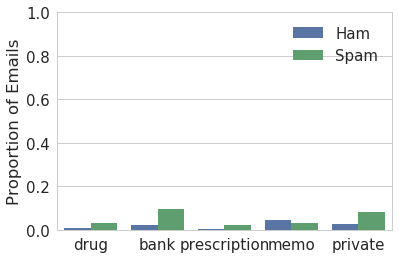

In [27]:
# YOUR CODE HERE

sns.barplot(x=pro1.index,y='pro',hue='spam',data=pro1);
plt.ylabel('Proportion of Emails');
plt.legend();
plt.ylim([0,1]);
#raise NotImplementedError()

(a)Suppose we have a classifier that just predicts 0 (ham) for every email. There are o false positives, 1918 false negatives.

(b) Suppose we have a classifier that just predicts 0 (ham) for every email. Its accuracy on the training set is 0.745 and its recall on the training set is 0.

(c) The precision, recall, and false-alarm rate of the logistic regression classifier are 0.642, 0.114 and 0.021 respectively. There are much more false negatives than false positives.

(d) Our logistic regression classifier got 75.6% prediction accuracy (number of correct predictions / total). It works better comparing with predicting 0 for every email, which got 74.4% prediction accuracy.

(e) Given the word features we gave you above, one reason of this classifier is performing poorly is these words are not very useful in distingushing spam and ham emails. 

(f) I prefer logistic regreesion classifier.Becuase accuracy of predicting 0 for every email can not get higher than 74.4%.

# Part II - Moving Forward

With this in mind, it is now your task to make the spam filter more accurate. In order to get full credit on the accuracy part of this assignment, you must get at least **88%** accuracy on the evaluation set. To see your accuracy on the evaluation set, you will use your classifier to predict every email in the `evaluation` DataFrame and upload your predictions to Kaggle.

To prevent you from fitting to the evaluation set, you may only upload predictions to Kaggle twice per day. This means you should start early and rely on your **test data** to estimate your Kaggle scores.  

Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!' were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

You may use whatever method you prefer in order to create features. However, **you are only allowed to train logistic regression models and their regularized forms**. This means no random forest, k-nearest-neighbors, neural nets, etc.

We will not give you a code skeleton to do this, so feel free to create as many cells as you need in order to tackle this task. However, answering questions 7, 8, and 9 should help guide you.

---

**Note:** *You should use the **test data** to evaluate your model and get a better sense of how it will perform on the Kaggle evaluation.*

---

In [28]:
import re
def fix_data(data):
    data['html'] = 0
    data.loc[data.loc[:,'email'].str.contains('<html>'),'html']=1
    
    data['body'] = 0
    data.loc[(data.iloc[:,2].str.lower().str.findall('<body>').str.len()) < (data.iloc[:,2].str.lower().str.findall('<\/body>').str.len()),'body'] = 1 
    
    data['email'] = (data.iloc[:,2]
                    .str.replace('<[^>]+>','')
                     .str.replace('[\s]+',' ')
                    )
    data['subject'] = data.iloc[:,1].str.findall('Subject:(.*)').str[0].fillna('')
    return data


In [29]:
def is_reply(data):
    data.loc[:,'is_reply']=0
    data.loc[data.iloc[:,1].str.lower().str.contains('re:'),'is_reply']=1
    return data


In [30]:
def upper_case_fraction(data):
    upper_num = data.iloc[:,2].str.findall('[A-Z]').str.len()
    letter_num =data.iloc[:,2].str.findall('[A-Za-z ]').str.len()
    data.loc[:,'upper_case_fraction'] = upper_num/letter_num
    return data


In [31]:
def upper_case_fractions(data):
    upper_num = data.iloc[:,1].str.findall('[A-Z]').str.len()
    letter_num =data.iloc[:,1].str.findall('[A-Za-z ]').str.len()
    data['upper_case_fractions'] = upper_num/letter_num
    return data


In [32]:
def character_fraction(data):
    data['character_fraction'] = 0
    data.loc[ data.iloc[:,2].str.findall('[a-zA-Z]').str.len()/data.iloc[:,2].str.len()>=0.83,'character_fraction'] = 1
    data.loc[data.iloc[:,2].str.findall('[a-zA-Z]').str.len()/data.iloc[:,2].str.len()<=0.3,'character_fraction'] = 1
    return data



In [33]:
def exclam_fraction(data):
    exclam_num = data.iloc[:,2].str.findall('!').str.len()
    total_num = data.iloc[:,2].str.findall("\W").str.len()
    data['exclam_fraction'] = exclam_num/total_num
    return data


In [34]:
def free_fraction(data):
    data['free_fraction'] = 6*data.iloc[:,2].str.lower().str.findall(' free ').str.len()/ data.iloc[:,2].str.len()
    data.loc[data.iloc[:,2].str.lower().str.findall(' free ').str.len()==1 ,'free_fraction'] = 0
    return data


In [35]:
def http_fraction(data):
    http_num = data.iloc[:,2].str.lower().str.findall('http:').str.len()
    total_num = data.iloc[:,2].str.len()
    data['http_fraction'] = 60*http_num/total_num
    return data


In [36]:
def reply_uppers(data):
    data.loc[:,'reply_uppers'] = data.loc[:,'is_reply']*data.loc[:,'upper_case_fractions']
    return data


In [37]:
def reply_upper(data):
    data.loc[:,'reply_upper'] = data.loc[:,'is_reply']*data.loc[:,'upper_case_fraction']
    return data


In [38]:
def reply_free(data):
    data.loc[:,'reply_free'] = data.loc[:,'is_reply']*data.loc[:,'free_fraction']
    return data


In [39]:
def reply_exclam(data):
    data.loc[:,'reply_exclam'] = data.loc[:,'is_reply']*data.loc[:,'exclam_fraction']
    return data


In [40]:
def space_fraction(data):
    data['space_fraction'] = 0
    data.loc[data.iloc[:,2].str.lower().str.findall(' ').str.len()/data.iloc[:,2].str.len()<=0.032,'space_fraction'] = 1 
    data.loc[data.iloc[:,2].str.lower().str.findall(' ').str.len()/data.iloc[:,2].str.len()>=0.20,'space_fraction'] = 1 

    return data


In [41]:
def i_fraction(data):
    data['i_fraction']=150*data.iloc[:,2].str.lower().str.findall('( i )|( i\')').str.len()/data.iloc[:,2].str.len()
    return data


In [42]:
def please_fraction(data):
    data['please_fraction'] = 6*data.iloc[:,2].str.lower().str.findall('please').str.len()/data.iloc[:,2].str.len()
    data.loc[data.iloc[:,2].str.lower().str.findall('please').str.len()<=2,'please_fraction'] = 0
    return data


In [43]:
def is_yellow(data):
    horny = data.iloc[:,2].str.lower().str.findall('horny').str.len()
    penis =  data.iloc[:,2].str.lower().str.findall('penis').str.len()
    cum =  data.iloc[:,2].str.lower().str.findall(' cum').str.len()
    fuck = data.iloc[:,2].str.lower().str.findall('fuck').str.len()
    sex = data.iloc[:,2].str.lower().str.findall('sexy?').str.len()

    data['is_yellow'] =horny + penis + cum + fuck + sex
    return data


In [44]:
def is_base64(data):
    data['is_base64'] = 0
    data.loc[data.iloc[:,2].str.contains('base64'),'is_base64'] = 1
    return data


In [45]:
def base_upper(data):
    data['base_upper'] = data['is_base64']*data['upper_case_fraction']
    return data


In [46]:
def not_word_fractions(data):
    data['not_word_fractions'] = 0
    data.loc[data.iloc[:,1].str.findall('[a-zA-Z0-9]').str.len()/data.iloc[:,1].str.findall('\w').str.len()<=0.8,'not_word_fractions'] = 1
    return data


In [47]:
def not_word_fraction(data):
    data['not_word_fraction'] =data.iloc[:,2].str.findall('[a-zA-Z0-9]').str.len()/data.iloc[:,2].str.findall('\w').str.len()
    return data


In [48]:
def standardize_columns(data):   
    return (data-np.mean(data))/(np.std(data))

In [49]:
def select_columns(data, *columns):
    return data.loc[:, columns]

def process_data_fm(data):
    data = data.pipe(fix_data)
    
    words_email = [' e-?mail ','offers?',' do not ','(\$[0-9])|(usd?[0-9])',' our ',
                   'contact','click here ','(^url)|(^http)','article','dear','[0-9]\%','remove',
                   'assist','reply','!!!','\d-\d\d\d-\d\d\d-\d\d\d\d',' cnet ',
                   ' order ','guarantee',' name ','rpm',' but' ,' -- ',' receive ',' & ',' business ',' send ',' > ',
                  ' 2002 ',' some ',' wrote ',' version ',' insurance ',' cash ', ' \* ','content-transfer-encoding:',
                  ' management ',' united ',' \| ',' =20 ']

    words_subject =['!','\$|money|sale','adv',' you','free','\[(sa)?.*\]','[ ]{3}']
    
    words_email_upper = [' We ',' To ',' FREE ',' If ',' DO ',' Web ',' New ',' REPORT ',' City: ',' THE ']
    
    email_mar = words_in_texts(words_email,data.iloc[:,2].str.lower())
    
    subject_mar = words_in_texts(words_subject,data.iloc[:,1].str.lower())
    
    upper_mar = words_in_texts(words_email_upper,data.iloc[:,2])
    
    data = (
        data
        # Transform data
        .pipe(is_reply)
        .pipe(upper_case_fraction)
        .pipe(upper_case_fractions)
        .pipe(character_fraction)
        .pipe(exclam_fraction)
        .pipe(free_fraction)
        .pipe(http_fraction)
        .pipe(reply_upper)
        .pipe(reply_uppers)
        .pipe(reply_free)
        .pipe(reply_exclam)
        .pipe(space_fraction)
        .pipe(i_fraction)
        .pipe(please_fraction)
        .pipe(is_yellow)
        .pipe(is_base64)
        .pipe(base_upper)
        .pipe(not_word_fractions)
        .pipe(not_word_fraction)
        .pipe(select_columns, 
              'spam',
              'is_reply',
              'upper_case_fraction', 
              'upper_case_fractions', 
              'character_fraction',  
              'exclam_fraction',
              'free_fraction',   
              'http_fraction',
              'reply_upper',
              'reply_uppers',
              'reply_free',
              'reply_exclam',
              'html',
              'space_fraction',
              'i_fraction',
              'please_fraction',
              'is_yellow',
              'is_base64',
              'base_upper',
              'not_word_fractions',
              'not_word_fraction',
              'body',
             )
        
    )
    
    data = pd.concat([data,pd.DataFrame(email_mar,index=data.index,columns = words_email)],axis=1)
    data = pd.concat([data,pd.DataFrame(subject_mar,index=data.index,columns = words_subject)],axis=1)
    data = pd.concat([data,pd.DataFrame(upper_mar,index=data.index,columns = words_email_upper)],axis=1)

    # Return predictors and response variables separately
    X = standardize_columns(data).drop(['spam'], axis = 1).fillna(0.0)
    y = data['spam']
    
    return X, y

final_model = sklearn.linear_model.LogisticRegressionCV(fit_intercept=True, Cs=10, cv=5)

In [51]:
# Process the data
[train_final, test_final] = train_test_split(original_data, test_size=0.1, random_state=42)

X_train, y_train = process_data_fm(train_final)
X_test, y_test = process_data_fm(test_final)


# Fit and predict
final_model.fit(X_train, y_train)
y_predicted = final_model.predict(X_test)

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

numpy.ndarray

In [52]:
sum(final_model.predict(X_train) == y_train)/len(y_train)

0.9759084253959803

In [53]:
sum(y_predicted == y_test)/len(y_test)

0.9712574850299401

In [54]:
training_ham = training_data.loc[(training_data['spam']==0),:]
training_spam = training_data.loc[(training_data['spam']==1),:]

In [55]:
flag = 0
if flag:
    from collections import Counter
    list_ham=np.sum(training_ham.iloc[:,2].str.split())
    counts_ham = Counter(list_ham)
    list_spam=np.sum(training_spam.iloc[:,2].str.split())
    counts_spam = Counter(list_spam)
    counts_ham = dict(counts_ham)
    key_ham = [k for k in counts_ham if counts_ham[k] <=len(training_ham)*0.02]
    counts_spam = dict(counts_spam)
    key_spam = [k for k in counts_spam if counts_spam[k]>=len(training_spam)*0.9]
    lst=[]
    for key in key_spam:
        if key not in key_ham:
            lst.append(key)

# Question 7 (Feature/Model Selection Process)

In this following cell, describe the process of improving your model. You should use at least 2-3 sentences each to address the follow questions:

1. How did you find better features for your model?
2. What did you try that worked / didn't work?
3. What was surprising in your search for good features?

1.

I calculated the words frequency in the email text for training_ham and traning_spam respectively to find which words are the best at distinguishing emails. By this method, i found a lot of great words like " but " and " receive ".

I also dug into the email texts and compare structure of ham emails and spam emails. I found that a majority of spam emails are involved with money and with strong sentiment, so that the words " FREE ", "!!" often show up in spam emails. And also whether this email is a reply matters a lot.

2.

I compared the words frequency to find better words at distingushing emails. I pick up those words with high frequencies in ham emails and with low frequencies in spam emails or those words with high frequencies in spam emails and with low frequencies in hpam emails. And these words work well at distingushing ham and spam emails.

I also wonder whether the length of the email matters in distingushing ham and spam emails, but it does not work very well. So i don not use this feature.

3.

When using the words frequency method to find words, there are some good but unexpected words such as the word  " -- ". The proportion of ham emails that contain " -- " is about 0.4 and the proportion of spam emails is only about 0.15. It really surprises me because i can not figure out why this word is useful.


# Question 8 (EDA)

In the two cells below, show a visualization that you used to select features for your model. Include both

1. A plot showing something meaningful about the data that helped you during feature / model selection.
2. 2-3 sentences describing what you plotted and what its implications are for your features.

Feel to create as many plots as you want in your process of feature selection, but select one for the cells below.

**You should not show us a visualization just like in question 3.** Specifically, don't show us a bar chart of proportions, or a one-dimensional class conditional density plot. Any other plot is acceptable, as long as it comes with thoughtful commentary. Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap`). 
1. Try to show redundancy in a group of features (e.g. `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all html tags and compare it to these). 
1. Use a word-cloud or another visualization tool to characterize the most common spam words.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

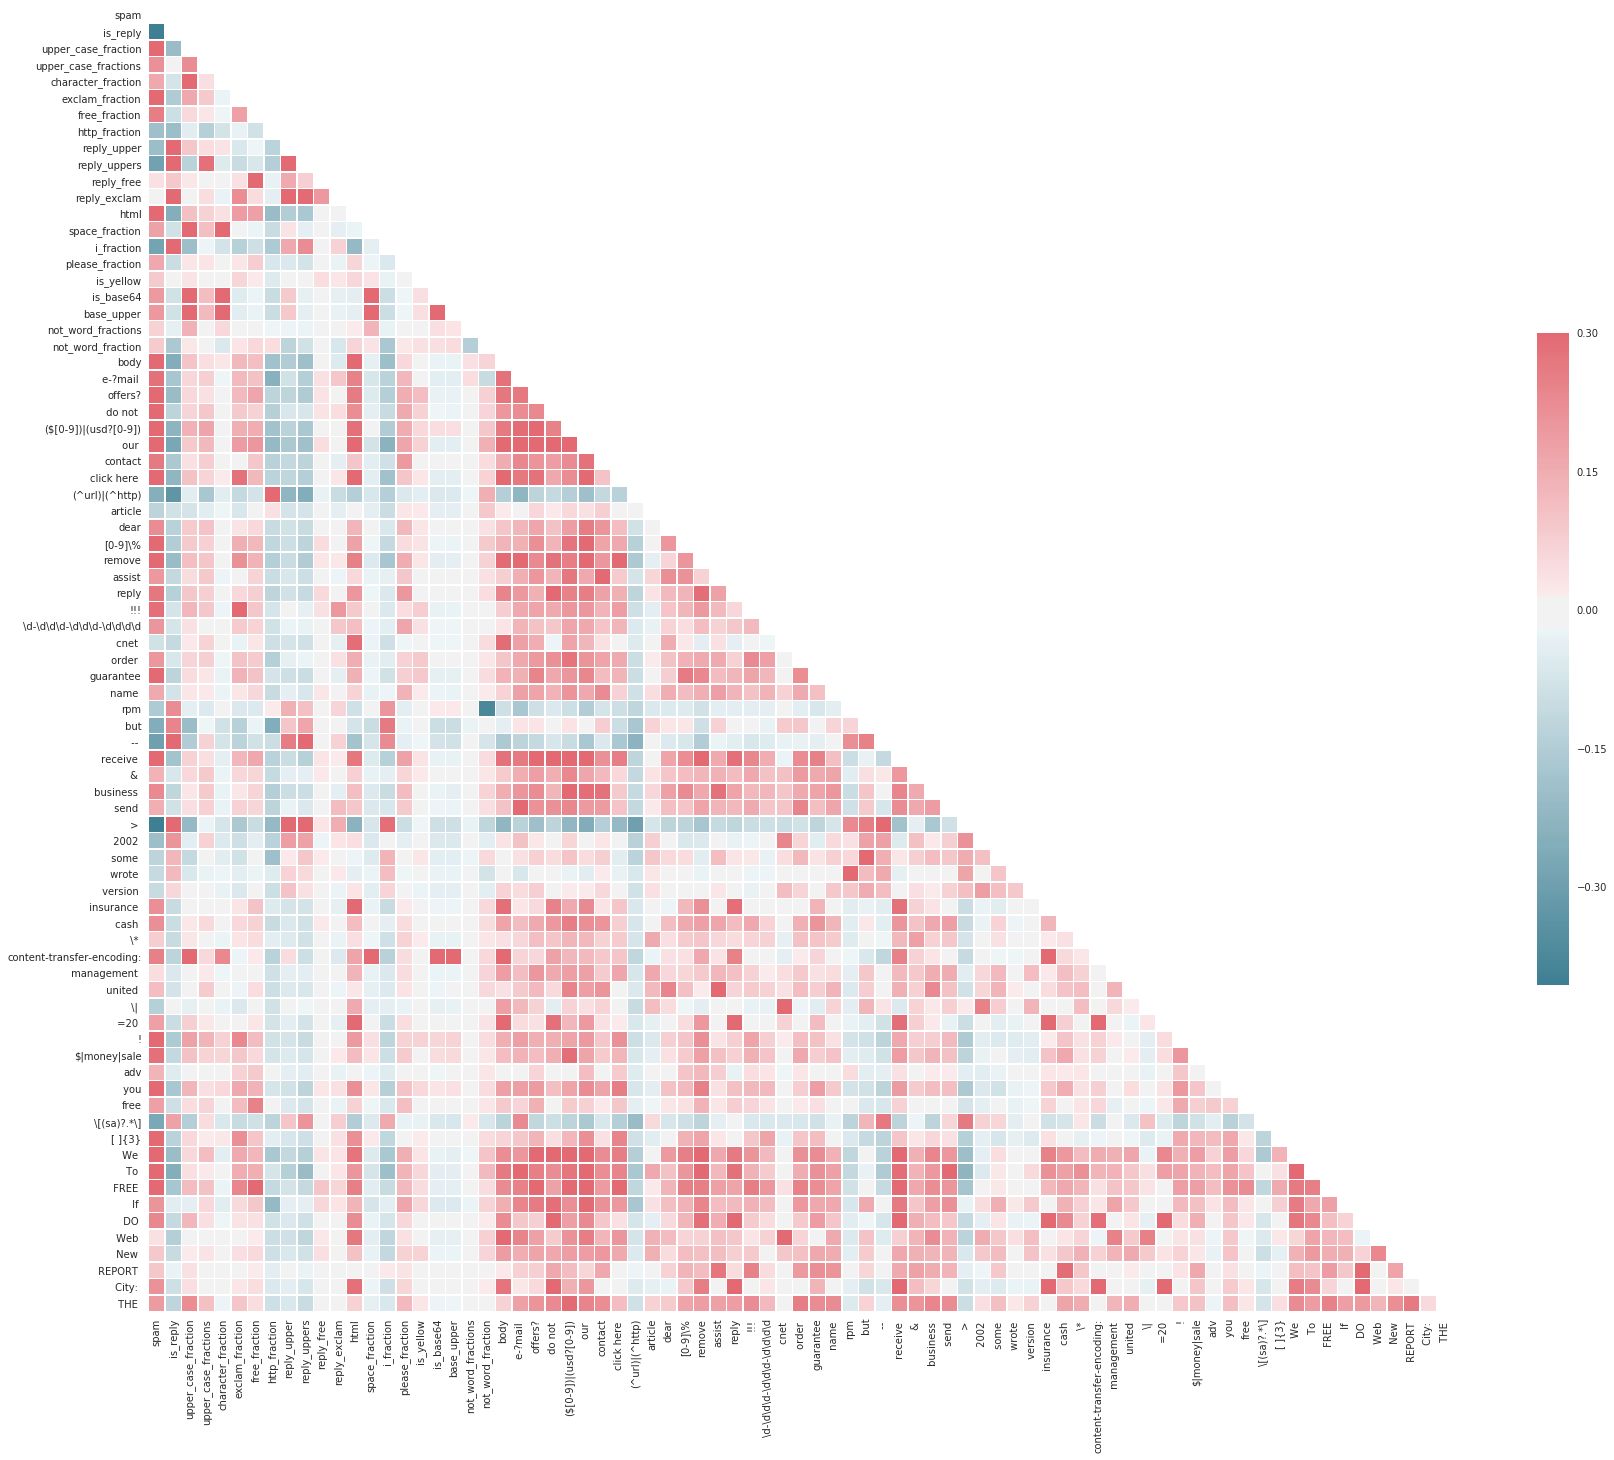

In [59]:
sns.set(style="white")

# Compute the correlation matrix
corr = pd.concat([y_train,X_train],axis=1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 24))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The plot above is the visualization of correlations between multiple features. 

When i did model selction, i will observe the correlations between spam and all other features. I notice that they range from -0.4 yo 0.3 and features "upper_case_fraction","exclam_fraction",">" are highly correlated with spam, which means that they are very useful at distingushing ham and spam emails. 

I also observe the correlation between other features. For example, the correlation between "rpm" amd "not_word_fraction" is high at around -0.4, but it is acceptable because it is still not high enough to lay great influences on the stablity of the final model.

# Question 9 (Making a Precision-Recall Curve)

We can trade off between precision and recall. In most cases we won't be able to get both perfect precision (i.e. no false positives) and recall (i.e. no false negatives), so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover a disease until it's too late to treat, while a false positive means that a patient will probably have to take another screening.

Recall that logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The precision-recall curve shows this trade off for each possible cutoff probability. In the cell below, [plot a precision-recall curve](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#plot-the-precision-recall-curve) for your final classifier (the one you use to make predictions for Kaggle).

Text(0.5,1,'2-class Precision-Recall curve: AP=0.99')

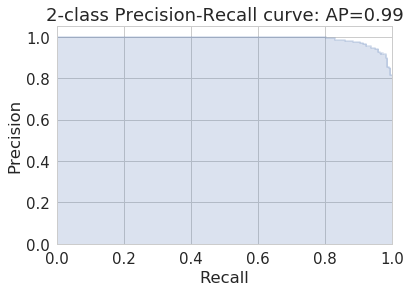

In [56]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = final_model.decision_function(X_test)

average_precision = average_precision_score(y_test, y_score)

precision, recall, _  = precision_recall_curve(y_test , y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
# Note that you'll want to use the .predict_proba(...) method for your classifier
# instead of .predict(...) so you get probabilities, not classes

# YOUR CODE HERE
#raise NotImplementedError()

# Question 10: Submitting to Kaggle

The following code will write your predictions on the evaluation dataset to a CSV, which you can submit to Kaggle. You may need to modify it to suit your needs.

Save your predictions in a 1-dimensional array called `evaluation_predictions`. *Even if you are not submitting to Kaggle, please make sure you've saved your predictions to `evaluation_predictions` as this is how your grade for this part will be determined.*

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the evaluation data in order to make predictions. For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use scikit-learn's `.predict(...)` method.

You should submit your CSV files to https://www.kaggle.com/t/39fae66747b14fd48fe0984f2e4f16ac

In [57]:
# CHANGE ME (Currently making random predictions)
evaluation = pd.read_csv('data/eval.csv')
X_evaluation,y_evaluation = process_data_fm(evaluation)
evaluation_predictions = final_model.predict(X_evaluation)
# YOUR CODE HERE
#raise NotImplementedError()

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/indexing.py:858: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



In [58]:
# must be ndarray of predictions
assert isinstance(evaluation_predictions, np.ndarray) 

# must be binary labels (0 or 1) and not probabilities
assert np.all((evaluation_predictions == 0) | (evaluation_predictions == 1))

# must be the right number of predictions
assert evaluation_predictions.shape == (1000, )

In [59]:
# Please do not modify this cell

The following saves a file to submit to Kaggle.

In [60]:
from datetime import datetime

# Assuming that your predictions on the evaluation set are stored in a 1-dimensional array called
# evaluation_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# must be ndarray of predictions
assert isinstance(evaluation_predictions, np.ndarray) 

# must be binary labels (0 or 1) and not probabilities
assert np.all((evaluation_predictions == 0) | (evaluation_predictions == 1))

# must be the right number of predictions
assert evaluation_predictions.shape == (1000, )

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": evaluation['id'], 
    "Class": evaluation_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Kaggle for scoring.')

Created a CSV file: submission_2018-04-30T04:30:44.csv.
You may now upload this CSV file to Kaggle for scoring.
